## Introduction

This notebook describes the analysis of extracellular recording data from Loren Frank Lab. The data was downloaded from CRNS website ( https://portal.nersc.gov/project/crcns/download/hc-6 ). These are tetrode recordings from the medial Entorhinal Corectex (mEC) and hippocampus of male rats. I have plans to understand coherence in certain freequency intervals from the LFP traces and we will look into spiking of units/cells related to spatial aspects of the experiments and temporal aspects of the Local Field Potential (LFP) recordings. The statistics of slow-gamma and fast-gamma oscillations will be captured. I have plan to uncover the reduced dimensional representations using some embedding methods (locally linear embeddings, autoencoders, etc.) and to see how they are organized according to the phase of theta rhythm.

In [129]:
import numpy as np
from numpy.fft import rfft
import scipy.io
from scipy import signal
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

# Import utilities for loading and plotting data
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
from neurodsp.filt import filter_signal

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

It was the 9th day of the experiment. 'Five' the rate was alternating between two branches of a W-shaped track/maze to get the rewards kept at the end of those branches. By then it had been trained well to perform this behaviour with near perfection. As it was learning to perfect this behaviour, tetrodes placed in the two regions of the sub-cortical structures, CA1 and medial Entorhinal Cortex (mEC), were recording the local electrical activity that was generated by thousand of neurons. Among them were neurons in close proximity to the tips of those electrodes, whose unique, charecteristic shape of action potential can be used to delineate their spiking pattern from the rest of the population chatter. Armed with this window into the cognitive processing of the rat, we will try to explore and answer some interesting questions pertaining to the neural processing/dynamics relevent to the behaviour of the animal and structural organization of the local circuits. 

In [5]:
pos = np.genfromtxt("g:/Arun/neural_data/hc-6/Fiv/processed_data/FivePos09_04.csv", delimiter=",")

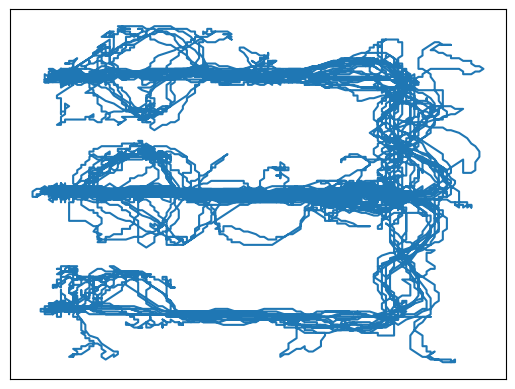

In [130]:
fig = plt.figure()
plt.plot(pos[:,1], pos[:,2])
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Major features of LFP
Peaks at Theta and gamma oscillation frequencies (Not pronouced in this LFP traces) in 
the spectrogram

In [131]:
def plot_spectrum_lfp(day, epoch):
    fname = "g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg0{}-{}-01.mat".format(day, epoch)
    print(fname)
    dat_all = scipy.io.loadmat(fname, squeeze_me=True, chars_as_strings=True)
    # print(dat_all.keys())
    eeg = dat_all['eeg'][-1][-1]
    print(eeg)
    eeg = eeg.tolist()
    print(eeg[4])
    start_time = eeg[2]
    sampling_rate = eeg[3]
    end_time = start_time+len(eeg)*(1/sampling_rate)
    T = end_time-start_time
    
    eeg = np.asarray(eeg[4])
    tim = np.linspace(start_time, end_time,len(eeg))

    dt = 1/sampling_rate
    df = 1/T

    print("dt: ", dt)
    print("df: ", df)
    
    sig = eeg-eeg.mean()
    # Mean of spectrogram (Welch)
    freq_mean, psd_mean = compute_spectrum(sig, sampling_rate, method='welch', avg_type='mean', nperseg=sampling_rate*2)

    # Median of spectrogram ("median Welch")
    freq_med, psd_med = compute_spectrum(sig, sampling_rate, method='welch', avg_type='median', nperseg=sampling_rate*2)

    # Median filtered spectrum
    freq_mf, psd_mf = compute_spectrum(sig, sampling_rate, method='medfilt')


    # Plot the power spectra
    plot_power_spectra([freq_mean[:200], freq_med[:200], freq_mf[100:10000]],
                   [psd_mean[:200], psd_med[:200], psd_mf[100:10000]],
                   ['Welch', 'Median Welch', 'Median Filter FFT'])

    

g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg09-4-01.mat
('eeg data from 01-168.eeg: 01:01:25 to 01:16:30\n', 'eegamplitude', 3684.9968, 1500.0001104956175, array([-82, -77, -70, ..., 299, 293, 279], dtype=int16), 168)
[-82 -77 -70 ... 299 293 279]
dt:  0.000666666617557507
df:  250.0000184231808


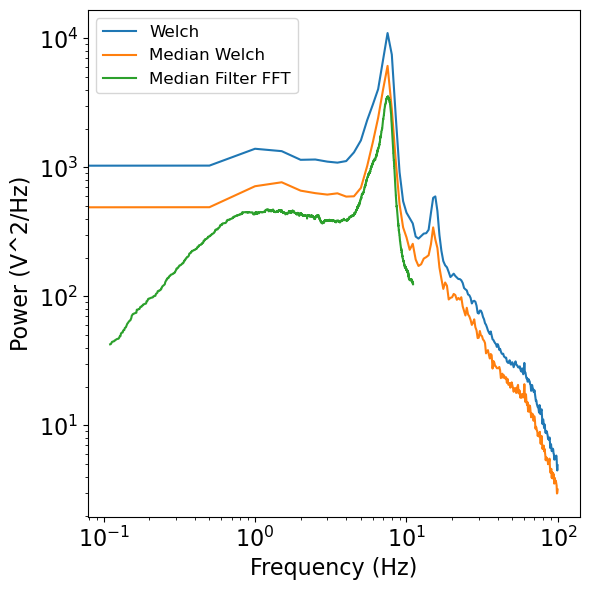

In [132]:
plot_spectrum_lfp(9,4)

## LFP with bandpassed traces in theta, slow-gamma and fast-gamma frequencies

In [171]:
def plot_filtered_theta_with_lfp(day, epoch):
    fname = "g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg0{}-{}-01.mat".format(day, epoch)
    print(fname)
    dat_all = scipy.io.loadmat(fname, squeeze_me=True, chars_as_strings=True)
    # print(dat_all.keys())
    eeg = dat_all['eeg'][-1][-1]
    print(eeg)
    eeg = eeg.tolist()
    print(eeg[4])
    start_time = eeg[2]
    sampling_rate = eeg[3]
    end_time = start_time+len(eeg[4])*(1/sampling_rate)
    T = end_time-start_time
    print("T:", T)
    eeg = np.asarray(eeg[4])
    tim = np.linspace(start_time, end_time,len(eeg))

    dt = 1/sampling_rate
    df = 1/T

    print("dt: ", dt)
    print("df: ", df)
    
    sig = eeg-eeg.mean()


    fNQ = 1 / dt / 2

    Wn = [5,15]
    n = 100
    b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
    Vlo = signal.filtfilt(b, 1, sig);

    ## Slow gamma
    Wn = [25,55]
    n = 100
    b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
    Vlo_sg = signal.filtfilt(b, 1, sig);

    ## Fast gamma
    Wn = [60,100]
    n = 100
    b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
    Vlo_fg = signal.filtfilt(b, 1, sig);

    phi = np.angle(signal.hilbert(Vlo))


    fig = plt.figure(figsize=(18,6))
    gs = mpl.gridspec.GridSpec(8,1)
    ax1 = fig.add_subplot(gs[0:4,0])
    ax2 = fig.add_subplot(gs[4:,0])
    # ax3 = fig.add_subplot(gs[6,0])

    ax1.plot(tim[:], eeg[:],label='LFP',c='k')
    ax1.plot(tim[:], Vlo,label="theta",c='r')
    ax1.set_xlim([3684.99924, 3688])#3684.99926])
    ax1.set_ylim([-500,500])
    # ax1.set_ylabel("LFP (mV)")
    # ax1.set_xlabel("Time (seconds)")
    plt.legend()

    # ax2.plot(tim[:], eeg[:],'k')
    ax2.plot(tim[:], Vlo_sg,label="slow gamma", c='b')
    ax2.set_xlim([3684.99924, 3688])#3684.99926])
    ax2.set_ylim([-100,100])  
    # plt.legend()

    # ax2.plot(tim[:], eeg[:],'k')
    ax2.plot(tim[:], Vlo_fg,label="fast gamma", c='g')
    ax2.set_xlim([3684.99924, 3688])#3684.99926])
    ax2.set_ylim([-100,100])  
    plt.legend()
    plt.show()

g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg09-4-01.mat
('eeg data from 01-168.eeg: 01:01:25 to 01:16:30\n', 'eegamplitude', 3684.9968, 1500.0001104956175, array([-82, -77, -70, ..., 299, 293, 279], dtype=int16), 168)
[-82 -77 -70 ... 299 293 279]
T: 905.0132666666668
dt:  0.000666666617557507
df:  0.0011049561778063068


C:\Users\Acer\AppData\Local\Temp\ipykernel_22872\2995457903.py:31: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
C:\Users\Acer\AppData\Local\Temp\ipykernel_22872\2995457903.py:37: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
C:\Users\Acer\AppData\Local\Temp\ipykernel_22872\2995457903.py:43: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  b = signal.firwin(n, Wn, nyq=fNQ, pass_zero=False, window='hamming');
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


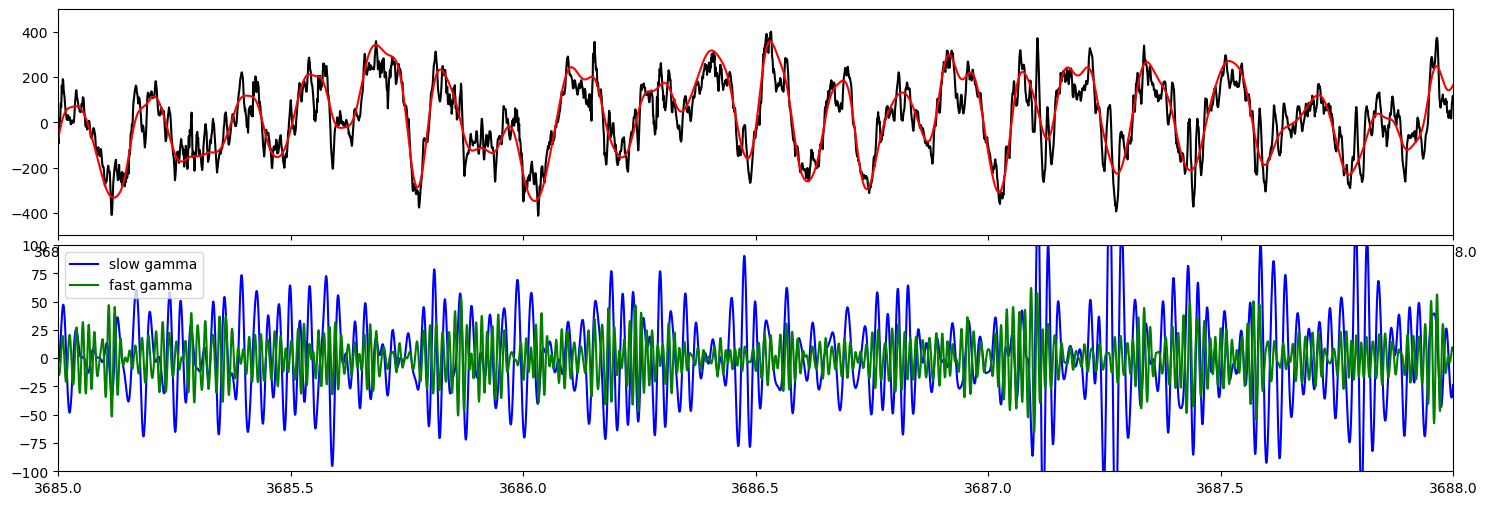

In [172]:
plot_filtered_theta_with_lfp(9,4)

g:/Arun/neural_data/hc-6/Fiv/Fivspikes09.mat


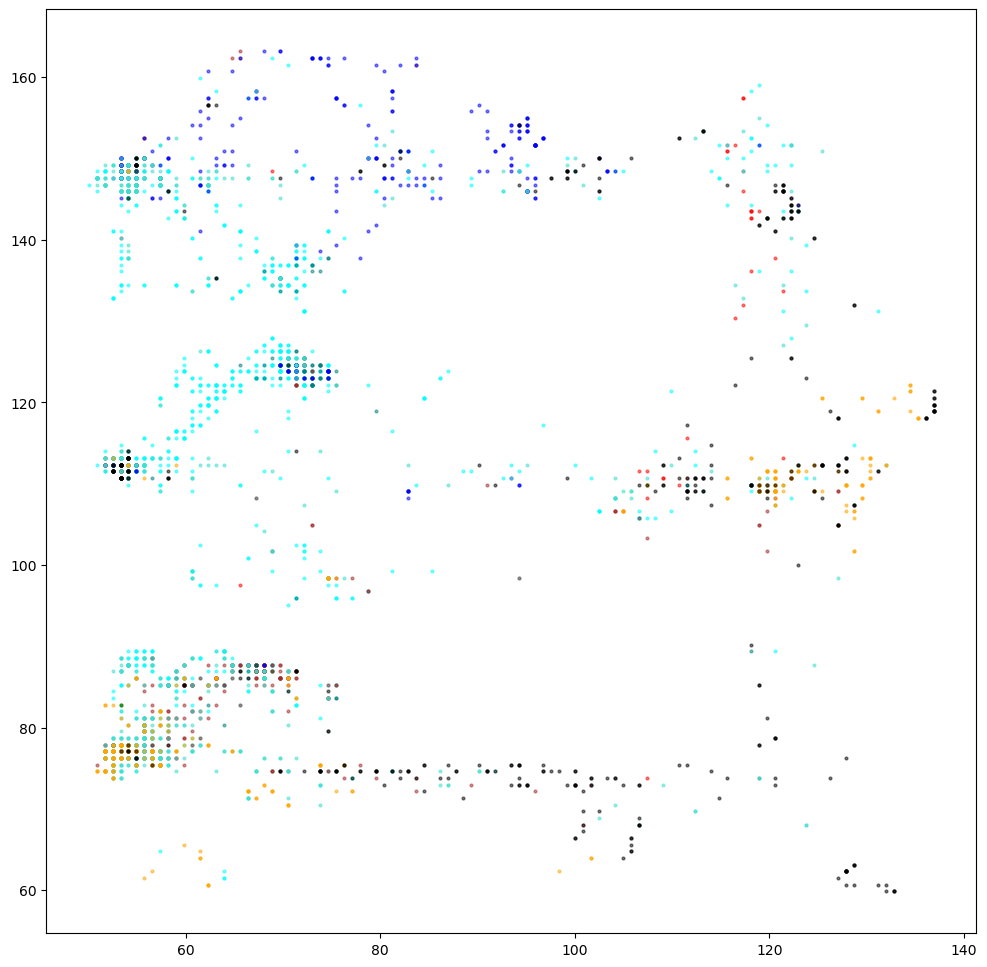

In [82]:

file_list = ["g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_7-1.csv", 
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_16-1.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_16-2.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_16-3.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_16-4.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_22-2.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_22-3.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_22-4.csv",
"g:/Arun/neural_data/hc-6/Fiv/processed_data/FiveSpikes09_04_22-5.csv"]

colors = ["red","cyan","teal","green","brown","blue","turquoise","orange","black"]

plt.figure(figsize=(12,12))
for iter,fname in enumerate(file_list):
    spiketimes = np.genfromtxt(fname, delimiter=",")
    plt.scatter(spiketimes[:,1],spiketimes[:,2],c=colors[iter],s=4,alpha=0.5)



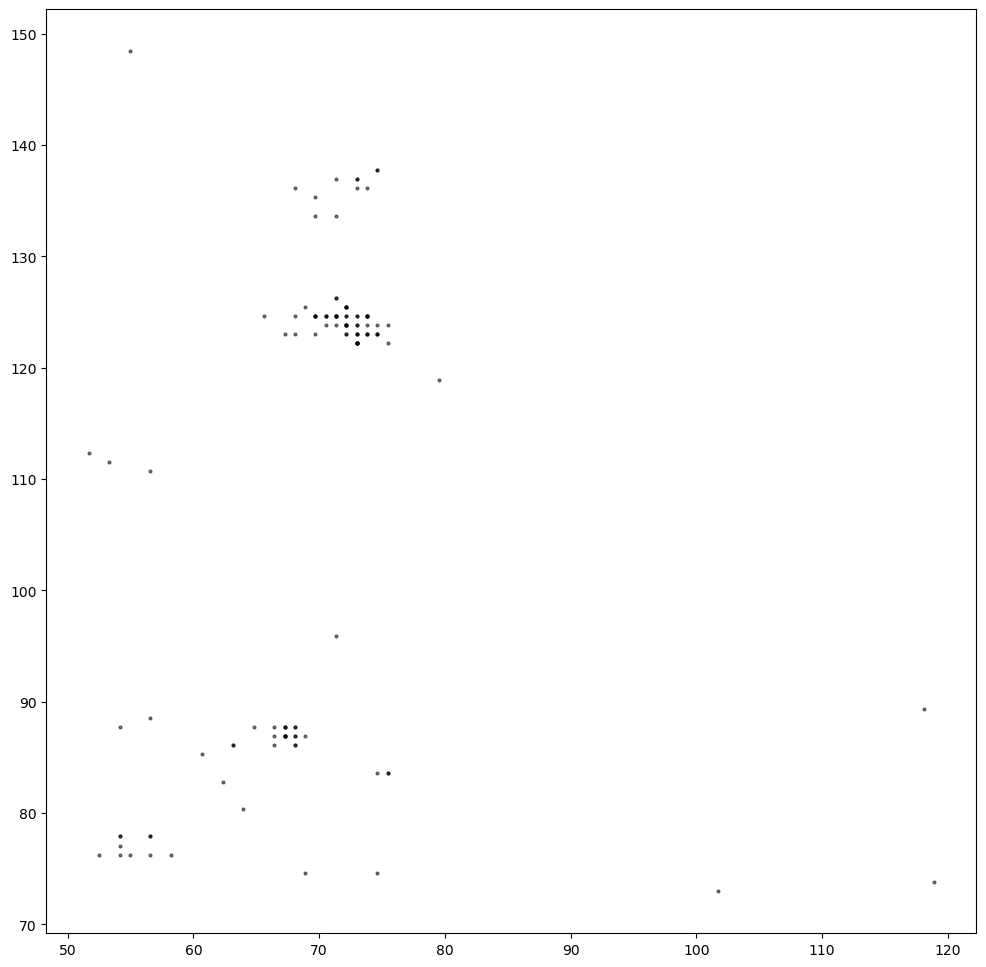

In [123]:
plt.figure(figsize=(12,12))
fname = file_list[2]
spiketimes = np.genfromtxt(fname, delimiter=",")
plt.scatter(spiketimes[:,1],spiketimes[:,2],c="k",s=4,alpha=0.5)

In [125]:
len(spiketimes[:,0])

125

In [121]:
def plot_heatmap_phase(day, epoch):
    fname = "g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg0{}-{}-16.mat".format(day, epoch)
    print(fname)
    dat_all = scipy.io.loadmat(fname, squeeze_me=True, chars_as_strings=True)
    # print(dat_all.keys())
    eeg = dat_all['eeg'][-1][-1][-1]
    print(eeg)
    eeg = eeg.tolist()
    print(eeg[4])
    start_time = eeg[2]
    sampling_rate = eeg[3]
    end_time = start_time+len(eeg[4])*(1/sampling_rate)
    T = end_time-start_time
    
    eeg = np.asarray(eeg[4])
    tim = np.linspace(start_time, end_time,len(eeg))

    dt = 1/sampling_rate
    df = 1/T

    print("dt: ", dt)
    print("df: ", df)
    
    sig = eeg-eeg.mean()


    fNQ = 1 / dt / 2

    Wn = [5,15]
    n = 100
    b = signal.firwin(n, Wn, fs=fNQ, pass_zero=False, window='hamming');
    Vlo = signal.filtfilt(b, 1, sig);
    phi = np.angle(signal.hilbert(Vlo))


    return start_time, end_time

In [122]:
plot_heatmap_phase(9,4)

g:/Arun/neural_data/hc-6/Fiv/EEG/Fiveeg09-4-16.mat
('eeg data from 16-106.eeg: 01:01:25 to 01:16:30\n', 'eegamplitude', 3684.9968, 1500.0001104956175, array([ -60,  -66, -103, ...,  125,  145,  111], dtype=int16), 106)
[ -60  -66 -103 ...  125  145  111]
dt:  0.000666666617557507
df:  0.0011049561778063068


(3684.9968, 4590.010066666667)

## Immediate plans
We will collect all the units/cells whose spikes are recorded in the dataset. We would like to know the answers to following questions.
1) What is the proportion of spatially modulated cells? are there any overrepresentation of particular places from the w-track?
2) If we can bin the locations where the spiking of cells were modulated by the theta rhythm (or gamma) will they cover the track uniformly? or will there be places where the spike-coherence is largest?  